In [41]:
#importing libs
import matplotlib.pyplot as plt
import matplotlib.image as matimg
import os
import numpy as np
%matplotlib inline

In [42]:
#Initialization
f=50#focal length
x_resolution=1024
y_resolution=1024
sigma=3#defocus level
#need to add more

# Mathmatical Modeling

1. Calc. of Rotational Mat. M

In [43]:
def getRotationalMat(alpha_0,delta_0,phi_0):
    """Gets the ascension, declination and role angle as inputs and return a rotational matrix"""
    a1=(np.sin(alpha_0)*np.cos(phi_0))-(np.cos(alpha_0)*np.sin(delta_0)*np.sin(phi_0))
    a2=(-np.sin(alpha_0)*np.sin(phi_0))-(np.cos(alpha_0)*np.sin(delta_0)*np.cos(phi_0))
    a3=-np.cos(alpha_0)*np.cos(delta_0)
    b1=(-np.cos(alpha_0)*np.cos(phi_0))-(np.sin(alpha_0)*np.sin(delta_0)*np.sin(phi_0))
    b2=(np.cos(alpha_0)*np.sin(phi_0))-(np.sin(alpha_0)*np.sin(delta_0)*np.cos(phi_0))
    b3=-np.sin(alpha_0)*np.cos(delta_0)
    c1=np.cos(alpha_0)*np.sin(phi_0)
    c2=np.cos(alpha_0)*np.cos(phi_0)
    c3=-np.sin(delta_0)
    M=np.array([
        [a1,a2,a3],
        [b1,b2,b3],
        [c1,c2,c3]
    ],dtype="float64")
    return M.transpose()



In [45]:
def obtainStarSensorCoordinateSystem(M_T,alpha_i,delta_i):
    """
    M_T=Transpose of orthogonal matrix. ie. Rotational Matrix
    alpha_i=ith ascension
    delta_i=ith declination
    """
    direction_vector_of_stars_in_celestial_coord_sys=np.array([
        [np.cos(alpha_i)*np.cos(delta_i)],
        [np.sin(alpha_i)*np.cos(delta_i)],
        [np.sin(delta_i)]
    ],dtype="float64")
    return np.multiply(M_T,direction_vector_of_stars_in_celestial_coord_sys)

# Condition stars ascension and declenation in the cameras FOV frame

In [48]:
def checkStarsAlphaDeltaWithInFOV(alpha_i,delta_i,alpha_0,delta_0,FOVx,FOVy):
    """
    Takes stars position, camera position and FOV as input and checks whether
    stars position is within camera FOV frame
    If returns True, stars position is within FOV
    """
    alpha_0=camera[0]
    delta_0=camera[1]
    R=np.sqrt((FOVx**2)+(FOVy**2))/2
    rangeOfAlpha=np.array([alpha_0-(R/np.cos(delta_0)),alpha_0+(R/np.cos(delta_0))])
    rangeOfDelta=np.array([delta_0-R,delta_0+R])
    return np.logical_and(rangeOfAlpha[0]<alpha_i<rangeOfAlpha[1],rangeOfDelta[0]<delta_i<rangeOfDelta[1])
    

# Projection

In [50]:
def getPixelXY(f,res_x,res_y,sensor_coord_mat):
    proj_mat=np.array([
        [f,0,res_x/2],
        [0,f,res_y/2],
        [0,0,1]
    ])
    pixel_coord=np.multiply(proj_mat,sensor_coord_mat)
    return pixel_coord[:2]

In [36]:
from PIL import Image,ImageDraw
img = Image.new("RGB", (1024, 1024), (0, 0, 0))

In [37]:
draw=ImageDraw.Draw(img)

In [39]:
draw.point((500,500),fill=(255,255,255))

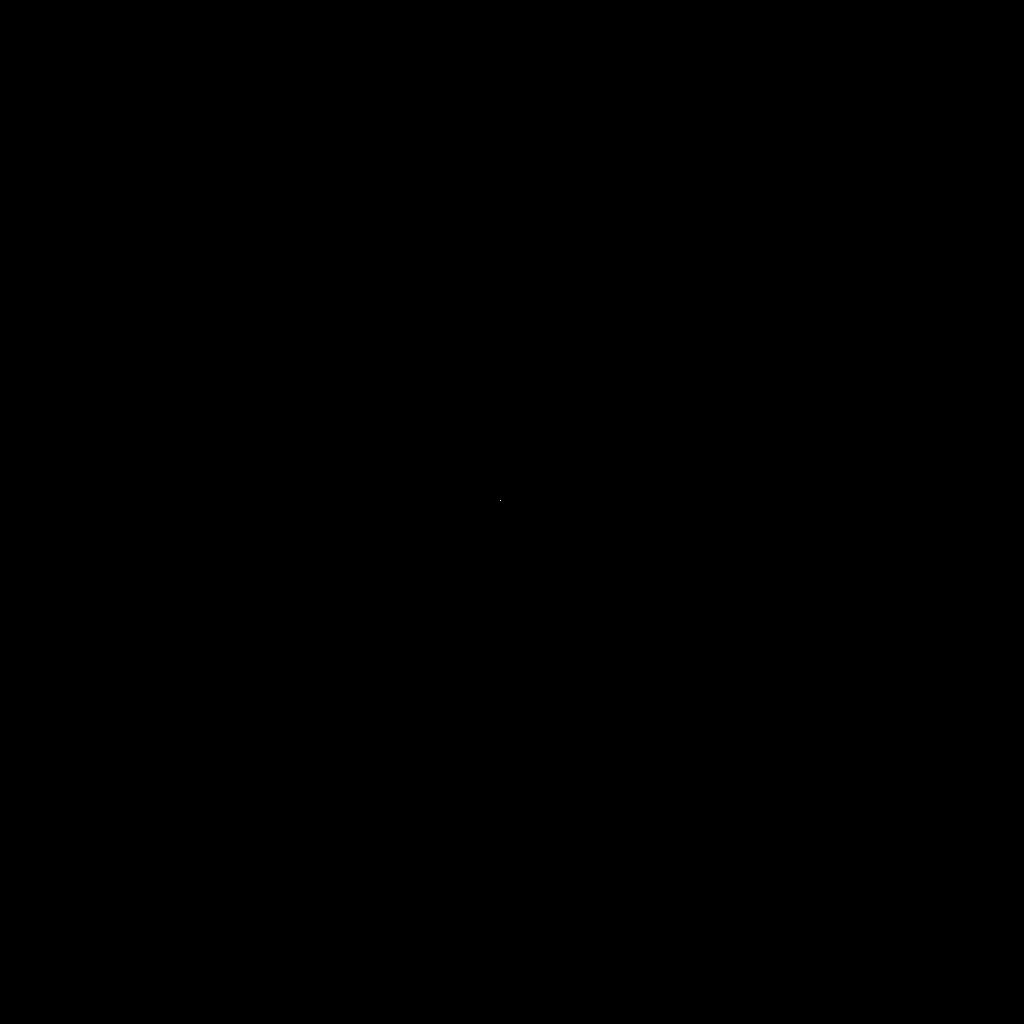

In [40]:
img